# Композиции классификаторов

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Библиотеки

In [3]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
from sklearn import base
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, BaggingClassifier)
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.datasets import make_classification, load_wine
from sklearn.model_selection import train_test_split

In [4]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (10,10)

## DummyEnsemble

Самый простой вариант ансамблирования это обучение нескольких моделей $b_t\bigr(x\bigr)$ и усреднение ответов:
$$
f\bigr(x\bigr) = \frac{1}{T}\sum_{t=1}^{T}b_t\bigr(x\bigr)
$$
В чем минус данного метода?

In [5]:
class DummyEnsemble(object):
    def __init__(self, base_estimator=None, n_estimators=10):
        self.n_estimators = n_estimators
        self.base_estimator = DecisionTreeClassifier(max_depth=1)
        if base_estimator:
            self.base_estimator = base_estimator
            
        self.b = [base.clone(self.base_estimator) for _ in range(self.n_estimators)]
        
    def get_params(self, deep=True):
        return {'n_estimators': self.n_estimators, 
                'base_estimator': self.base_estimator}
        
    def fit(self, X, Y):
        for b in self.b:
            b.fit(X, Y)
            
    def predict(self, X):
        probas = self.predict_proba(X)
        return np.argmax(probas, axis=1)
    
    def predict_proba(self, X):
        return np.mean([elem.predict_proba(X) for elem in self.b], axis=0)

In [6]:
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=6)
model = DummyEnsemble()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.646 (0.036)


In [7]:
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=6)
model = DummyEnsemble(LogisticRegression())

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.800 (0.034)


In [8]:
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=6)
model = DummyEnsemble(SVC(probability=True))

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.937 (0.021)


## AdaBoost

Основная идея алгоритма состоит в том, чтобы итеративно дообучать модели на объектах, которые плохо классифицируются предыдущими моделями, при помощи их перевзвешивания.

$$
\sum_{i=1}^{l}\exp\bigr(-y_i\sum_{t=1}^{T}\alpha_tb_t\bigr(x_i\bigr)\bigr)\exp\bigr(-y_i\alpha_Tb_T\bigr(x_i\bigr)\bigr) \to \min_{\alpha_T, b_T}
$$

In [27]:
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=6)

In [25]:
AdaBoostClassifier?

Init signature:
AdaBoostClassifier(
    estimator=None,
    *,
    n_estimators=50,
    learning_rate=1.0,
    algorithm='deprecated',
    random_state=None,
)
Docstring:     
An AdaBoost classifier.

An AdaBoost [1]_ classifier is a meta-estimator that begins by fitting a
classifier on the original dataset and then fits additional copies of the
classifier on the same dataset but where the weights of incorrectly
classified instances are adjusted such that subsequent classifiers focus
more on difficult cases.

This class implements the algorithm based on [2]_.

Read more in the :ref:`User Guide <adaboost>`.

.. versionadded:: 0.14

Parameters
----------
estimator : object, default=None
    The base estimator from which the boosted ensemble is built.
    Support for sample weighting is required, as well as proper
    ``classes_`` and ``n_classes_`` attributes. If ``None``, then
    the base estimator is :class:`~sklearn.tree.DecisionTreeClassifier`
    initialized with `max_depth=1`.

  

In [28]:
model = AdaBoostClassifier()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.798 (0.034)


In [29]:
n_scores = cross_val_score(model, X, y, scoring='f1_weighted', cv=cv, n_jobs=-1, error_score='raise')
print('f1_weighted: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

f1_weighted: 0.798 (0.034)


In [11]:
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=6)
model = AdaBoostClassifier(SVC(probability=True))

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.741 (0.044)


In [12]:
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=6)
model = AdaBoostClassifier(LogisticRegression())

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.788 (0.038)


## Градиентный бустинг

$$
\sum_{i=1}^{l}\mathcal{L}\left(\sum_{t=1}^{T-1}\alpha_tb_t\bigr(x_i\bigr)+\alpha b\bigr(x_i\bigr)\right) \to \min_{\alpha, b}
$$

In [13]:
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=6)
model = GradientBoostingClassifier()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.888 (0.032)


## Bagging

In [14]:
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=6)
model = BaggingClassifier()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.839 (0.038)


In [15]:
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=6)
model = BaggingClassifier(SVC())

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.937 (0.021)


In [16]:
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=6)
model = BaggingClassifier(LogisticRegression())

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.800 (0.036)


## Случайный лес

В данном случае мы говорим о множестве решающих деревьев (отсюда и слово лес).
1. Для задачи классификации в листях деревьев лежит класс.
2. Для задачи регресии в листях лежит среднее значение ответов для всех объектов.

Случайный лес является ансамблем деревьев:
1. Для каждого дерева выбирается произвольное подмножество объектов.
2. Строится каждое дерево не завиимо друг от друга.

In [17]:
data = load_wine()
X = data['data']
Y = data['target']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=30, 
                                                    random_state=0)

In [18]:
model = RandomForestClassifier(n_estimators=6, max_depth=2, random_state=0)
model.fit(X_train, Y_train)
print(model.score(X_train, Y_train), model.score(X_test, Y_test))
print(classification_report(Y_test, model.predict(X_test)))

0.9797297297297297 0.9666666666666667
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      0.93      0.97        15
           2       0.86      1.00      0.92         6

    accuracy                           0.97        30
   macro avg       0.95      0.98      0.96        30
weighted avg       0.97      0.97      0.97        30



### Зависимость качества от числа деревьев

In [19]:
models = []
scores_train = []
scores_test = []
n_estimators = list(range(1, 20))
for estimators in n_estimators:
    model = RandomForestClassifier(n_estimators=estimators, random_state=0)
    model.fit(X_train, Y_train)
    models.append(model)
    scores_test.append(model.score(X_test, Y_test))
    scores_train.append(model.score(X_train, Y_train))

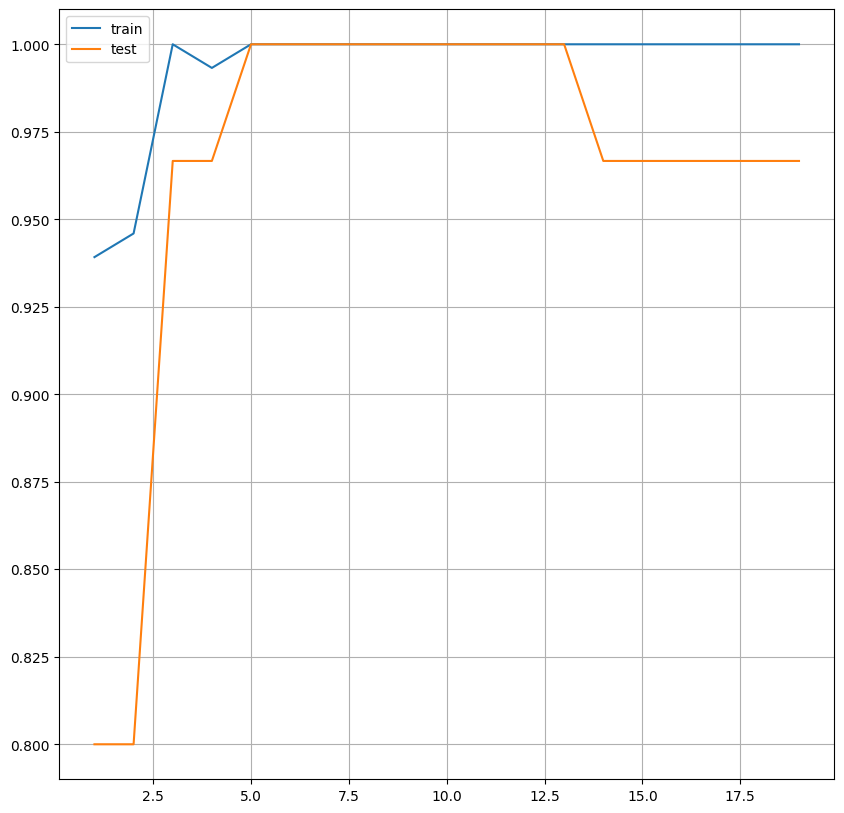

In [20]:
plt.plot(n_estimators, scores_train, label='train')
plt.plot(n_estimators, scores_test, label='test')

plt.legend(loc='best')
plt.grid()
plt.show()

### Зависимость качества от числа признаков при расщеплении

In [21]:
models = []
scores_train = []
scores_test = []
max_features = list(range(1, 13))
for features in max_features:
    model = RandomForestClassifier(n_estimators=6, 
                                   max_features=features, random_state=0)
    model.fit(X_train, Y_train)
    models.append(model)
    scores_test.append(model.score(X_test, Y_test))
    scores_train.append(model.score(X_train, Y_train))

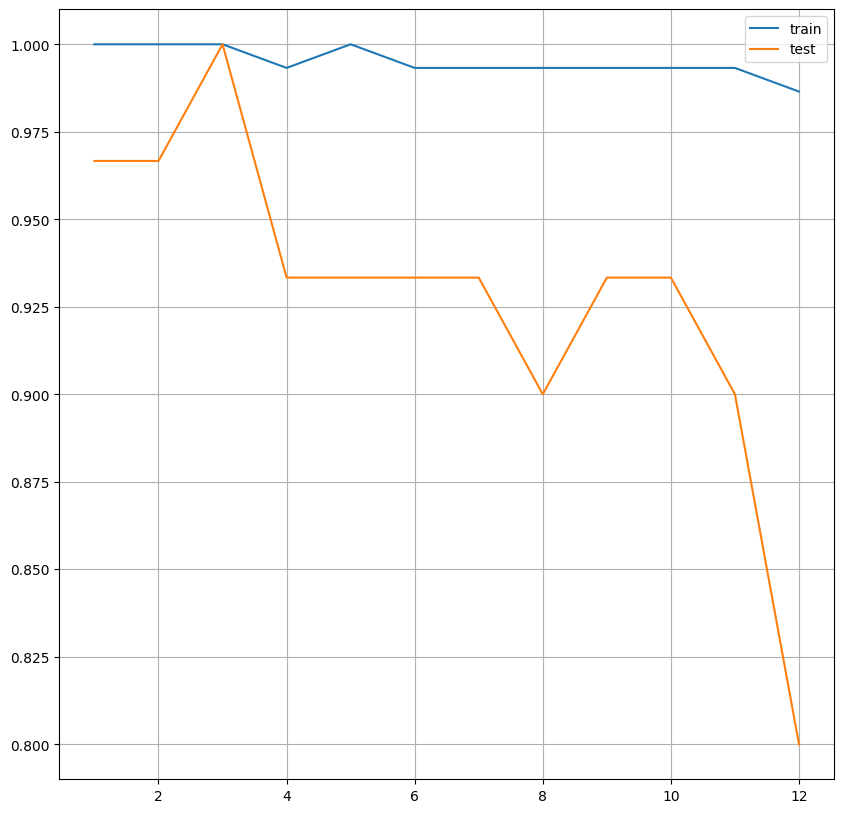

In [22]:
plt.plot(max_features, scores_train, label='train')
plt.plot(max_features, scores_test, label='test')

plt.legend(loc='best')
plt.grid()
plt.show()

### Зависимость качества от глубины деревьев

In [23]:
models = []
scores_train = []
scores_test = []
current_depth = []
max_depth = list(range(1, 10))
for depth in max_depth:
    model = RandomForestClassifier(n_estimators=6,
        max_depth=depth, random_state=0)
    model.fit(X_train, Y_train)
    models.append(model)
    scores_test.append(model.score(X_test, Y_test))
    scores_train.append(model.score(X_train, Y_train))
    current_depth.append(model.estimators_[0].get_depth()/depth)

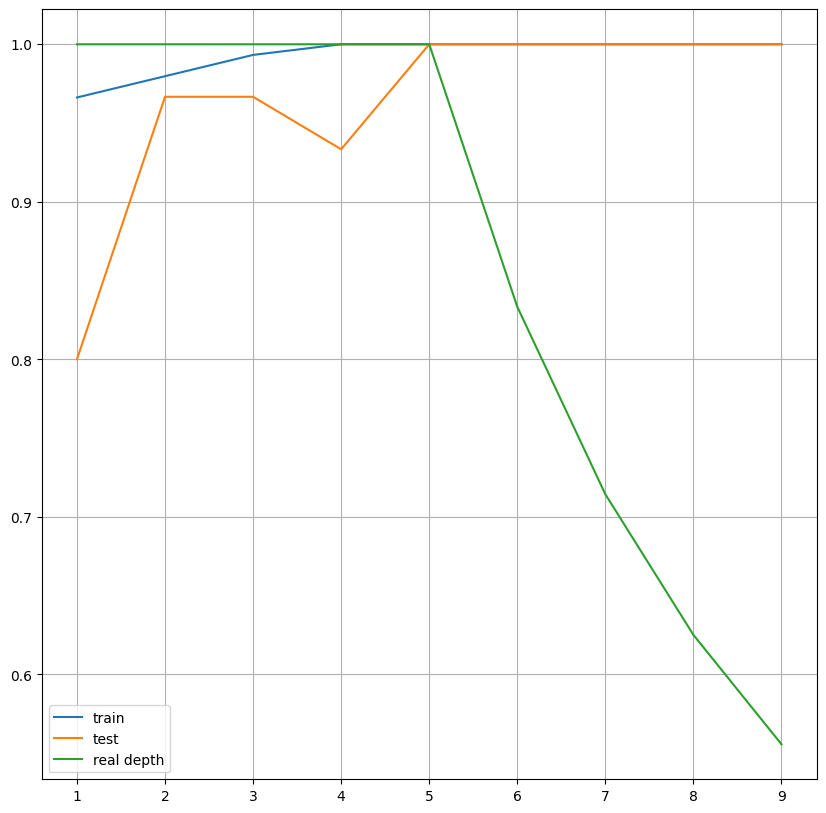

In [24]:
plt.plot(max_depth, scores_train, label='train')
plt.plot(max_depth, scores_test, label='test')
plt.plot(max_depth, current_depth, label='real depth')

plt.legend(loc='best')
plt.grid()
plt.show()

### Замечания по случайному лесу
1. Число деревьев нужно подбирать, так как большое количество деревьев увеличивает качество на обучении, но на валидации, может быть меньше или не меняться вовсе, но время обучении возрастает.
2. Важным параметров является число признаков, которые участвуют в построении правила разделение. Для классификации обычно используется $\sqrt{n}$, а для регрессии $\frac{n}{3}$. Параметр является важным, так как при его увеличении деревья становятся похожими друг на друга.
3. Параметр глубины деревьев можно не подбирать, так как деревья сами настроивают эту высоту. Но если выборка слишком шумная, от рекомендуется не использовать слишком глубокие деревья.

P.S все параметры нужно подбирать на кросс-валидации.